## Pre-Training LLM

In [1]:
import torch
import tiktoken

from classes.model import GPTModel

GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False 
}

In [2]:
class TextTokenConversion():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def encode(self, text):
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        return torch.tensor(encoded).unsqueeze(0)
    
    def decode(self, ids):
        return self.tokenizer.decode(ids.squeeze(0).tolist())

In [3]:
def generate_text_simple(model, idx, max_new_tokens, context_size):

    for _ in range(max_new_tokens):
        context = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(context)
        prob = torch.softmax(logits[:, -1, :], dim=-1)
        new_idx = torch.argmax(prob, dim=-1, keepdim=True)

        idx = torch.cat((idx, new_idx), dim=1)

    return idx

In [4]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG)
model.eval();

In [5]:
tt_convert = TextTokenConversion(
    tokenizer=tiktoken.get_encoding("gpt2")
)

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [7]:
new_token_ids = generate_text_simple(
    model,
    inputs,
    10,
    context_size=GPT_CONFIG["context_length"])


## Loss function (cross-entropy)

In [8]:
logits = model(inputs)
probs = torch.softmax(logits, dim=-1)

In [9]:
txt_id = 0
target_prob_1 = probs[txt_id, [0, 1, 2], targets[txt_id]]
print(target_prob_1)

tensor([7.4540e-05, 3.1061e-05, 1.1563e-05], grad_fn=<IndexBackward0>)


In [10]:
txt_id = 1
target_prob_2 = probs[txt_id, [0, 1, 2], targets[txt_id]]
print(target_prob_2)

tensor([1.0337e-05, 5.6776e-05, 4.7559e-06], grad_fn=<IndexBackward0>)


In [11]:
log_probs = torch.log(torch.cat((target_prob_1, target_prob_2)))
mean = -1 * torch.mean(log_probs)
print(mean)

tensor(10.7940, grad_fn=<MulBackward0>)


In [12]:
# using the built in function
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.7940, grad_fn=<NllLossBackward0>)

### losses for the whole training / validation sets

In [13]:
with open("data/the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()


from classes.dataloader import create_dataloader

train_ratio = 0.9
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
valid_data = raw_text[split_idx:]

In [14]:
# create data loader
torch.manual_seed(123)

train_loader = create_dataloader(
    train_data,
    tokenizer=tt_convert.tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

valid_loader = create_dataloader(
    valid_data,
    tokenizer=tt_convert.tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [15]:
# calculating loss
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )

    return loss

def calc_loss_loader(data_loader, model, device, num_bacthes=None):
    total_loss = 0

    if len(data_loader) == 0:
        return float("nan")
    elif num_bacthes is None:
        num_bacthes = len(data_loader)
    else:
        num_bacthes = min(num_bacthes, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_bacthes:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss / num_bacthes

In [16]:
# example
torch.manual_seed(123)
device = "cpu"

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    valid_loss = calc_loss_loader(valid_loader, model, device)

print(train_loss)
print(valid_loss)

tensor(10.9876)
tensor(10.9811)


## Training

In [17]:
def train_model_simple(
    model, train_loader, valid_loader, optimizer, device, 
    num_epochs, eval_freq, eval_iter, start_context, tt_convert):

    train_losses, valid_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # main loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # resets the gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # eval step
            if global_step % eval_freq == 0:
                train_loss, valid_loss = evaluate_model(model, train_loader, valid_loader, device, eval_iter)
                
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss: {train_loss:.3f}, Valid loss: {valid_loss:.3f}")
                
        generate_and_print_sample(model, tt_convert, device, start_context)

    return train_losses, valid_losses, track_tokens_seen


def evaluate_model(model, train_loader, valid_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_bacthes=eval_iter)
        valid_loss = calc_loss_loader(valid_loader, model, device, num_bacthes=eval_iter)
    
    model.train()
    return train_loss, valid_loss


def generate_and_print_sample(model, tt_convert, device, start_context):
    model.eval()

    context_size = model.position_emb.weight.shape[0]
    encoded = tt_convert.encode(start_context).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    decoded_text = tt_convert.decode(token_ids)
    print(decoded_text.replace("\n", " "))

    model.train()



In [18]:
torch.manual_seed(123)
device = "cpu"

model = GPTModel(GPT_CONFIG)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

In [19]:
num_epochs = 10

train_losses, valid_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    valid_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tt_convert=tt_convert
)

Epoch 1 (Step 000000): Train loss: 9.781, Valid loss: 9.933
Epoch 1 (Step 000005): Train loss: 8.072, Valid loss: 8.341
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2 (Step 000010): Train loss: 6.752, Valid loss: 7.044
Epoch 2 (Step 000015): Train loss: 6.094, Valid loss: 6.597
Every effort moves you, the,, the,, the,,,,.                                     
Epoch 3 (Step 000020): Train loss: 6.197, Valid loss: 6.821
Epoch 3 (Step 000025): Train loss: 5.237, Valid loss: 6.372
Every effort moves you.               "I was the picture.      "I was the the picture. "I the honour, and I had"I was.  
Epoch 4 (Step 000030): Train loss: 4.857, Valid loss: 6.277
Epoch 4 (Step 000035): Train loss: 4.207, Valid loss: 6.262
Every effort moves you, and I had been the picture of the picture.                                       
Epoch 5 (Step 000040): Train loss: 4.078, Valid loss: 6.243
Every effort moves you know it was not to the picture--I to the               

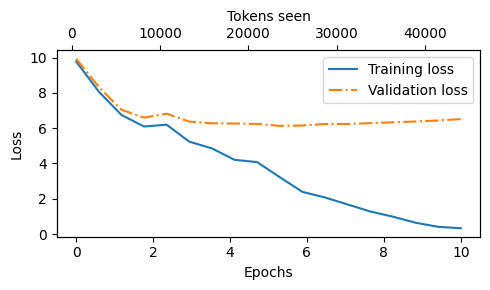

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, valid_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, valid_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, valid_losses)

## Save model weights to file

In [ ]:
model.save_weights("./weights/custom.pth")

## Text Generation Improvments

In [21]:
# this reloads modules recurrsively
import tools.reload_modules

In [46]:
%reload classes.generation
from classes.generation import generator

gen = generator(model=model, encoder=tt_convert)

In [29]:
gen.generate_and_print(start_context="Hello There ", num_gen_tokens=20, device=device, method="simple")

Hello There  sunlit terrace.  I glanced after him, struck by his last word. Victor Grind


## Temperature scalling

In [30]:
kwargs = {"temperature": 1}
gen.generate_and_print(start_context="Hello There ", num_gen_tokens=20, device=device, method="temperature", **kwargs)

Hello There  tossing wasographers rotting my surprise repl a cheap genius--I so inevitably the sweetness now it the log


# Combination with top-k sampling

In [ ]:
tokens = gen.generate_text(idx=gen.encoder.encode("Hello There "), max_new_tokens=20, temperature=1.4, topk=25)
print(gen.encoder.decode(tokens))

Hello There  slightly, without bitterness, and the mant of the deep arm-chairs forward.
"Never till
